# CESM2 SIT Frequency Analysis

In [3]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import glob
from matplotlib.gridspec import GridSpec
from matplotlib import cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib
import scipy.signal as signal
import statsmodels.api as sm
import scipy.stats as stats

In [4]:
def convert_coords(lat, lon, og_data, ccrs_grid):
    grid = ccrs_grid
    coords = grid.transform_points(ccrs.PlateCarree(), 
                                   np.array(lon), 
                                   np.array(lat))
    
    xs = np.ma.masked_invalid(coords[..., 0])
    ys = np.ma.masked_invalid(coords[..., 1])
    data = np.ma.masked_invalid(og_data)
    data.mask = np.logical_or(data.mask, xs.mask, ys.mask)
    
    xs = xs.filled(0)
    ys = ys.filled(0)
    
    return xs,ys,data

# Plotting functions 
def fashion_space(ax):
    ax.set_extent([-180,180,55,90], ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cfeature.LAND,facecolor = 'gainsboro', zorder=6)
    ax.gridlines()
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = matplotlib.path.Path(verts * radius + center)
    
    ax.set_boundary(circle, transform=ax.transAxes)

### Load CMIP6 data

In [5]:
cat = 'SIday' #SImon
variable = 'sithick' #sivoln
cmip_dir = '/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/piControl/r1i1p1f1/'+cat+'/'+variable+'/gn/files/d20190320/'

files = sorted(glob.glob(cmip_dir+variable+'_'+cat+'_CESM2_piControl_r1i1p1f1_gn_*[0-9]*'))

In [14]:
cmip_ds = xr.open_mfdataset(files[-3:-1], combine='by_coords')

/glade/u/home/mollyw/.local/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'sithick' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,


### Pre-process

In [15]:
SIT = cmip_ds.sithick.compute()

In [ ]:
def find_variability(timeseries, low, high, ):
    fs=1 #1 day in Hz (sampling frequency)

    nyquist = fs / 2 # 0.5 times the sampling frequency
    low_cutoff=0.02 # fraction of nyquist frequency, here  it is 5 days
    hi_cutoff = 0.1
    print('cutoff= ',1/hi_cutoff*nyquist,' days') #cutoff=  4.999999999999999  days
    b, a = signal.butter(5, [low_cutoff, hi_cutoff] , btype='bandpass') #low pass filter
    
    dUfilt = signal.filtfilt(b, a, SIT_sm)

In [9]:
fs=1 #1 day in Hz (sampling frequency)

nyquist = fs / 2 # 0.5 times the sampling frequency
low_cutoff=0.0027378507871321013/2# fraction of nyquist frequency, here  it is 5 days
hi_cutoff = 0.05
print('low cutoff= ',1/low_cutoff*nyquist,' days') #cutoff=  4.999999999999999  days
print('high cutoff= ',1/hi_cutoff*nyquist,' days') #cutoff=  4.999999999999999  days
b, a = signal.butter(5, low_cutoff , btype='lowpass') #low pass filter

# dUfilt = signal.filtfilt(b, a, SIT_sm)

low cutoff=  365.25  days
high cutoff=  10.0  days


In [16]:
SIT_weather = signal.filtfilt(b, a, SIT[:,355,193], axis = 0)

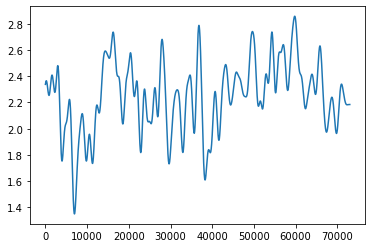

In [17]:
plt.plot(SIT_weather)

In [18]:
S_weather_var = SIT_weather-SIT_weather.mean(axis=0)

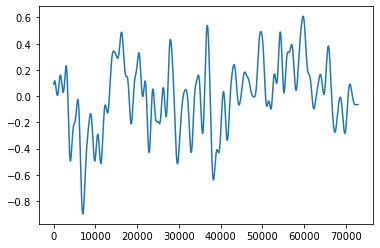

In [19]:
plt.plot(S_weather_var)

In [33]:
f0, Pxx0 = signal.welch(S_weather_var, fs=1*365, window = 'hann', nperseg=5096, detrend = 'linear', axis = 0)

(0.0, 1.0)

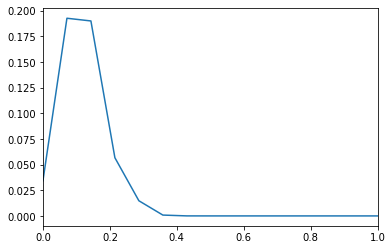

In [35]:
plt.plot(f0,Pxx0)
plt.xlim([0,1])

In [39]:
1/f0[2]

6.980821917808219

In [50]:
thing = SIT.groupby('time.').mean()

AttributeError: 'DatetimeAccessor' object has no attribute 'monthofyear'

In [47]:
maps = thing.var(axis=0)

In [48]:
data = maps
lat = SIT.lat
lon = SIT.lon
nps = ccrs.NorthPolarStereo()

xs,ys,plot_data=convert_coords(lat, lon, data, nps)

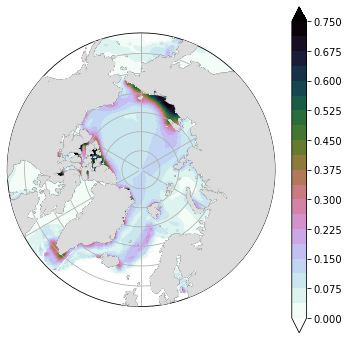

In [49]:
fig = plt.figure(figsize = (6,6))
ax = plt.axes(projection=nps)
fashion_space(ax)
cmap = plt.cm.cubehelix_r
clevs_label = np.linspace(0, 0.75, 11)
clevs = np.linspace(0,0.75, 21)
img = ax.contourf(xs, ys, data,clevs, transform=ccrs.NorthPolarStereo(), cmap=cmap, extend = 'both')
cbar2 = fig.colorbar(img, ax=ax, ticks= clevs_label)
# img = ax.contourf(xs, ys, data, transform=ccrs.NorthPolarStereo(), cmap=cmap, extend = 'both')
# cbar2 = fig.colorbar(img, ax=ax)

In [6]:
mean_SIT = SIT.mean(dim = ['ni','nj']).groupby('time.dayofyear').mean()
SIT_ly = SIT.mean(dim = ['ni','nj'])

In [7]:
gridcell1_m = SIT[:,355,193].groupby('time.dayofyear').mean() #central arctic
gridcell2_m = SIT[:,375,50].groupby('time.dayofyear').mean() #coastline
gridcell3_m = SIT[:,355,95].groupby('time.dayofyear').mean() #MIZ
gridcell4_m = SIT[:,370,200].groupby('time.dayofyear').mean()

gridcell1 = SIT[:,355,193]#central arctic
gridcell2 = SIT[:,375,50] #coastline
gridcell3 = SIT[:,355,95]
gridcell4 = SIT[:,370,200]

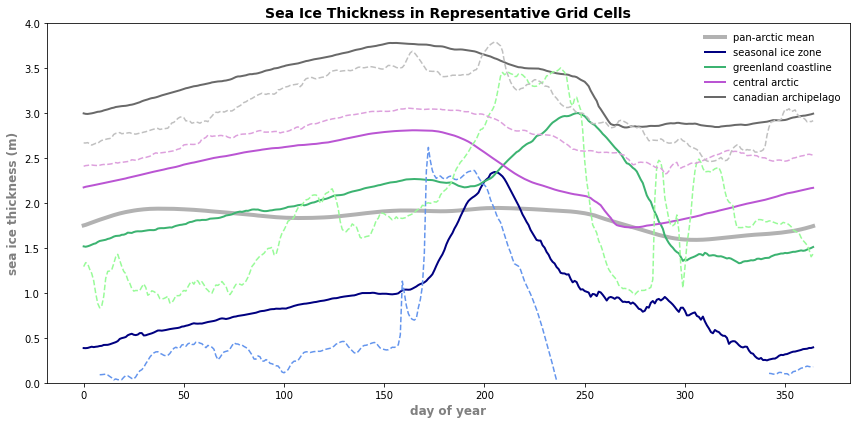

In [8]:
fig = plt.figure(figsize = (12, 6))

plt.plot(mean_SIT, c = 'black', linewidth = 4 , alpha = 0.3, label = 'pan-arctic mean')
plt.plot(gridcell3_m, c = 'navy', label = 'seasonal ice zone', linewidth = 2 )
plt.plot(gridcell2_m, c = 'mediumseagreen', label = 'greenland coastline', linewidth = 2)
plt.plot(gridcell1_m, c = 'mediumorchid', label = 'central arctic', linewidth = 2)
plt.plot(gridcell4_m, c = 'dimgrey', label = 'canadian archipelago', linewidth = 2)

plt.plot(gridcell3[-365:],'--', c = 'cornflowerblue')
plt.plot(gridcell2[-365:],'--',c = 'palegreen')
plt.plot(gridcell1[-365:],'--',c = 'plum')
plt.plot(gridcell4[-365:],'--',c = 'silver')


plt.ylim([0, 4])
plt.xlabel('day of year', fontsize = 12, fontweight = 'bold', color = 'grey')
plt.ylabel('sea ice thickness (m)', fontsize = 12, fontweight = 'bold', color = 'grey')
plt.legend(frameon=False)
plt.title('Sea Ice Thickness in Representative Grid Cells', fontsize = 14, fontweight = 'bold')
plt.tight_layout()

In [9]:
f3, Pxx3 = signal.welch(gridcell3.fillna(0), fs=1, window = 'hann', nperseg=5096, detrend = 'linear', axis = 0)
f2, Pxx2 = signal.welch(gridcell2.fillna(0), fs=1, window = 'hann', nperseg=5096, detrend = 'linear', axis = 0)
f1, Pxx1 = signal.welch(gridcell1.fillna(0), fs=1, window = 'hann', nperseg=5096, detrend = 'linear', axis = 0)
f0, Pxx0 = signal.welch(SIT_ly.fillna(0), fs=1, window = 'hann', nperseg=5096, detrend = 'linear', axis = 0)
f4, Pxx4 = signal.welch(gridcell4.fillna(0), fs=1, window = 'hann', nperseg=5096, detrend = 'linear', axis = 0)

In [10]:
## Red noise 
a0 = sm.tsa.acf(SIT_ly.fillna(0))[1]
a1 = sm.tsa.acf(gridcell1.fillna(0))[1]
a2 = sm.tsa.acf(gridcell2.fillna(0))[1]
a3 = sm.tsa.acf(gridcell3.fillna(0))[1]
a4 = sm.tsa.acf(gridcell4.fillna(0))[1]

/glade/u/home/mollyw/.conda/envs/single_assimilation/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:662: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  FutureWarning,
/glade/u/home/mollyw/.conda/envs/single_assimilation/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


In [11]:
## degrees of freedom
fw = 1.2
N = len(gridcell1.fillna(0))
M = 5096
dof = 2*N/M*fw

In [12]:
f_stat = stats.f.ppf(0.99, dof, dof)

In [13]:
f_stat

3.219143924358276

In [14]:
red0 = [(1-a0**2)/(1-2*a0*np.cos(omega)+a0**2) for omega in np.linspace(0, np.pi, len(f0))]
red1 = [(1-a1**2)/(1-2*a1*np.cos(omega)+a1**2) for omega in np.linspace(0, np.pi, len(f1))]
red2 = [(1-a2**2)/(1-2*a2*np.cos(omega)+a2**2) for omega in np.linspace(0, np.pi, len(f2))]
red3 = [(1-a3**2)/(1-2*a3*np.cos(omega)+a3**2) for omega in np.linspace(0, np.pi, len(f3))]
red4 = [(1-a4**2)/(1-2*a4*np.cos(omega)+a4**2) for omega in np.linspace(0, np.pi, len(f4))]

In [15]:
ratio0 = sum(Pxx0)/sum(red0)
ratio1 = sum(Pxx1)/sum(red1)
ratio2 = sum(Pxx2)/sum(red2)
ratio3 = sum(Pxx3)/sum(red3)
ratio4 = sum(Pxx4)/sum(red4)

In [16]:
Red0 = [r0*ratio0*f_stat for r0 in red0]
Red1 = [r1*ratio1*f_stat for r1 in red1]
Red2 = [r2*ratio2*f_stat for r2 in red2]
Red3 = [r3*ratio3*f_stat for r3 in red3]
Red4 = [r4*ratio4*f_stat for r4 in red4]

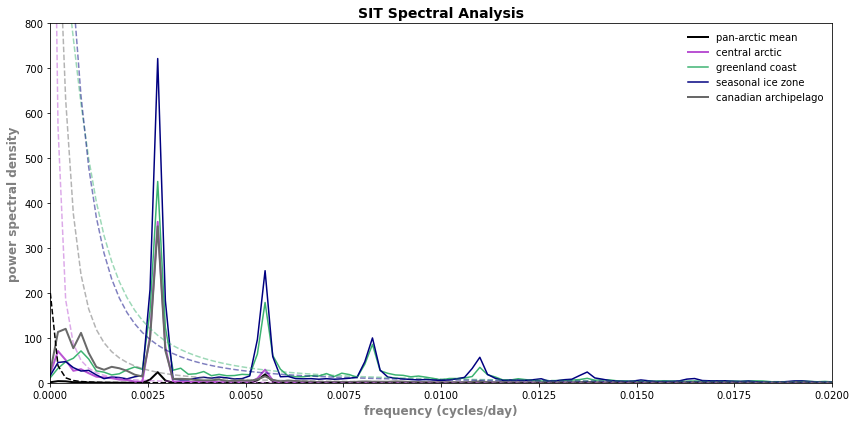

In [17]:
fig = plt.figure(figsize = (12,6))

plt.plot(f0, Pxx0, c = 'black', linewidth = 2, label = 'pan-arctic mean')
plt.plot(f1,Pxx1 , label= 'central arctic', c = 'mediumorchid', linewidth = 2)
plt.plot(f2, Pxx2, label = 'greenland coast',  c = 'mediumseagreen', linewidth = 1.5)
plt.plot(f3, Pxx3, label = 'seasonal ice zone', c = 'navy', linewidth = 1.5)
plt.plot(f4, Pxx4, label = 'canadian archipelago', c = 'dimgrey', linewidth = 2)
plt.plot(f0, Red0,'--', c = 'black')
plt.plot(f1, Red1,'--', c = 'mediumorchid', alpha = 0.5)
plt.plot(f2, Red2, '--', c = 'mediumseagreen',alpha = 0.5)
plt.plot(f3, Red3, '--', c = 'navy',alpha = 0.5)
plt.plot(f4, Red4, '--', c = 'dimgrey',alpha = 0.5)

plt.xlim([0, 0.02])
plt.ylim([0, 800])
plt.xlabel('frequency (cycles/day)', fontsize = 12, fontweight = 'bold', color = 'grey')
plt.ylabel('power spectral density', fontsize = 12, fontweight = 'bold', color = 'grey')
plt.legend(frameon=False)
plt.title('SIT Spectral Analysis', fontsize = 14, fontweight = 'bold')
plt.tight_layout()

In [29]:
for i in [14, 28, 41, 55, 69]:
    print(1/f1[i])

364.0
182.0
124.29268292682926
92.65454545454544
73.85507246376811


In [136]:
list(Pxx2)

[98.33491,
 153.55319,
 83.39883,
 59.3558,
 51.721878,
 120.312744,
 153.0468,
 30.264875,
 13.60259,
 11.930713,
 11.589851,
 9.961375,
 8.269531,
 8.524854,
 7.4412227,
 4.6886106,
 5.410251,
 3.9557211,
 4.0792193,
 4.1877575,
 3.7845597,
 2.9400864,
 2.9406874,
 2.8238027,
 2.8211753,
 2.592174,
 1.6079335,
 1.6444328,
 2.0029612,
 1.5223284,
 1.2955995,
 1.2467443,
 1.2972301,
 1.1450288,
 0.8827706,
 0.9775126,
 0.8926782,
 0.90952706,
 0.9355553,
 1.1431438,
 0.97059304,
 0.7108965,
 0.7170092,
 0.5738128,
 0.58202183,
 0.7383206,
 0.5451499,
 0.6777887,
 0.5959855,
 0.40413982,
 0.4688277,
 0.38329813,
 0.33930725,
 0.3411014,
 0.29178008,
 0.27902058,
 0.2906486,
 0.27602455,
 0.2536018,
 0.21521695,
 0.2927924,
 0.31013727,
 0.29154375,
 0.246998,
 0.23442657,
 0.25824484,
 0.21425304,
 0.22251163,
 0.24260698,
 0.24829188,
 0.22350636,
 0.2009208,
 0.169592,
 0.18276666,
 0.19158001,
 0.20694368,
 0.18819256,
 0.19105756,
 0.18744895,
 0.21937433,
 0.2251735,
 0.23175204,
 

In [18]:
data = SIT.mean(dim='time')
lat = SIT.lat
lon = SIT.lon
nps = ccrs.NorthPolarStereo()

In [19]:
siz_lat = SIT.lat[355,95]
siz_lon = SIT.lon[355,95]

ca_lat = SIT.lat[355,193]
ca_lon = SIT.lon[355,193]

car_lat = SIT.lat[370,200]
car_lon = SIT.lon[370,200]

gc_lat = SIT.lat[375,50]
gc_lon = SIT.lon[375,50]



xsiz, ysiz, pt_data = convert_coords(siz_lat, siz_lon, SIT[0,380,80], nps)
xca, yca, pt_data = convert_coords(ca_lat, ca_lon, SIT[0,380,80], nps)
xcar, ycar, pt_data = convert_coords(car_lat, car_lon, SIT[0,380,80], nps)
xgc, ygc, pt_data = convert_coords(gc_lat, gc_lon, SIT[0,380,80], nps)

xs,ys,plot_data=convert_coords(lat, lon, data, nps)

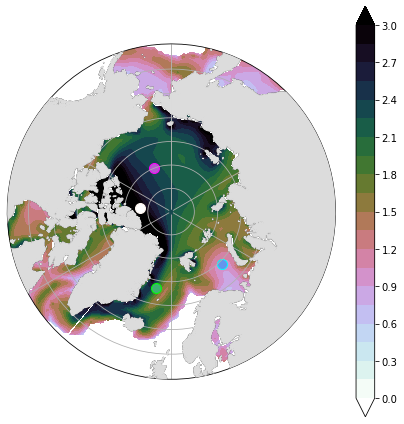

In [25]:
fig = plt.figure(figsize = (6,6))
ax = plt.axes(projection=nps)
fashion_space(ax)
cmap = plt.cm.cubehelix_r
clevs_label = np.linspace(0, 3, 11)
clevs = np.linspace(0, 3, 21)
img = ax.contourf(xs, ys, data,clevs, transform=ccrs.NorthPolarStereo(), cmap=cmap, extend = 'both')
ax.scatter(xsiz,ysiz,100, c = 'cornflowerblue', edgecolor = 'aqua')
ax.scatter(xca,yca,100, c = 'mediumorchid', edgecolor = 'fuchsia')
ax.scatter(xcar,ycar,100, c = 'white', edgecolor = 'seashell')
ax.scatter(xgc,ygc,100, c = 'mediumseagreen', edgecolor = 'lime')
cbar2 = fig.colorbar(img, ax=ax, ticks= clevs_label)
plt.tight_layout()

In [12]:
SIT[:,0,0].isnull().sum()

<xarray.DataArray 'sithick' ()>
array(0)
Coordinates:
    lat      float64 -79.22
    lon      float64 320.6
    ni       int32 1
    nj       int32 1

In [551]:
for i,j in zip(SIT.ni,SIT.nj):
    if SIT[:,i-1,j-1].isnull().sum() != 36500:
        SIT[:,i-1,j-1].fillna(0)
    else:
        pass
           

In [552]:
SIT

<xarray.DataArray 'sithick' (time: 36500, nj: 384, ni: 320)>
array([[[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [26.98226 , 26.137615, 26.78382 , ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [26.973402, 26.133806, 26.778532, ...,       nan,       nan,
               nan],
...
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [28.770388, 26.606035, 27.992212, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
    lat      (nj, ni) float64 -79.22 -79.22 -79.22 ... 9.969e+36 9.969e+36
    lon      (nj, ni) float64 320.6 321.7 322.8 ... 9.969e+36 9.969e+36
  * ni       (ni) int32 1 2 3 4 5 6 7 8 9 ... 313 314 315 316 317 318 319 320
  * nj       (nj) int32 1 2 3 4 5 6 7 8 9 ... 377 378 379 380 381 382 383 384
  * time     (time) object 1100-01-02 00:00:00 ... 1200-01-01 00:00:00
Attributes: (12/19)
    cell_measures:  area: areacello
    cell_methods:   area: time: mean where sea_ice (comment: mask=siconc)
    comment:        Actual (floe) thickness of sea ice (NOT volume divided by...
    description:    Actual (floe) thickness of sea ice (NOT volume divided by...
    frequency:      day
    id:             sithick
    ...             ...
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Sea Ice Thickness
    type:           real
    units:          m
    variable_id:    sithick

In [ ]:
if there is a non-nan in the timeseries of the location:
    replace all nans in timeseries at that point to 0

In [54]:
deasonalized = SIT.groupby('time.dayofyear') - SIT.groupby('time.dayofyear').mean(dim = 'time')

### Calculate spatial means

In [131]:
SIT_sm = SIT.mean(dim=['ni','nj']).compute()
# SIT_ann = SIT_sm.groupby('time.dayofyear').mean()
deseasonalized_sm = SIT_sm.groupby('time.dayofyear') - SIT_sm.groupby('time.dayofyear').mean()

In [6]:
# cmip_dir='/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/piControl/r1i1p1f1/SImon/sithick/gn/files/d20190320/'
# files = sorted(glob.glob(cmip_dir+'sithick_SImon_CESM2_piControl_r1i1p1f1_gn_*[0-9]*'))

In [7]:
# cmip_ds = xr.open_mfdataset(files[-2:-1], combine='by_coords')

In [8]:
# SIT_month = cmip_ds.sithick.where(cmip_ds.sithick > 0).fillna(0).mean(dim=['ni','nj'])

### Plot timeseries

In [444]:
fs=1 #1 day in Hz (sampling frequency)

nyquist = fs / 2 # 0.5 times the sampling frequency
low_cutoff=0.02 # fraction of nyquist frequency, here  it is 5 days
hi_cutoff = 0.1
print('cutoff= ',1/hi_cutoff*nyquist,' days') #cutoff=  4.999999999999999  days
b, a = signal.butter(5, [low_cutoff, hi_cutoff] , btype='bandpass') #low pass filter

cutoff=  5.0  days


In [446]:
dUfilt = signal.filtfilt(b, a, SIT_sm)

In [430]:
# deseasonalized_sm

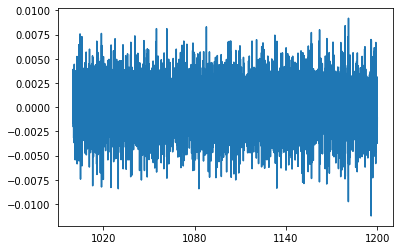

In [447]:
plt.plot(deseasonalized_sm.time, dUfilt)

### Perform frequency analysis

In [553]:
f, Pxx = signal.welch(SIT, fs=1, window = 'hann', nperseg=2048, detrend = False, axis = 0)

In [554]:
# plt.plot(f,Pxx)
# plt.xlim([0,0.1])

In [555]:
# 1/f[34]

In [556]:
# list(Pxx)

In [557]:
data = Pxx[11]

lat = SIT.lat
lon = SIT.lon
nps = ccrs.NorthPolarStereo()

xs,ys,plot_data=convert_coords(lat, lon, data, nps)

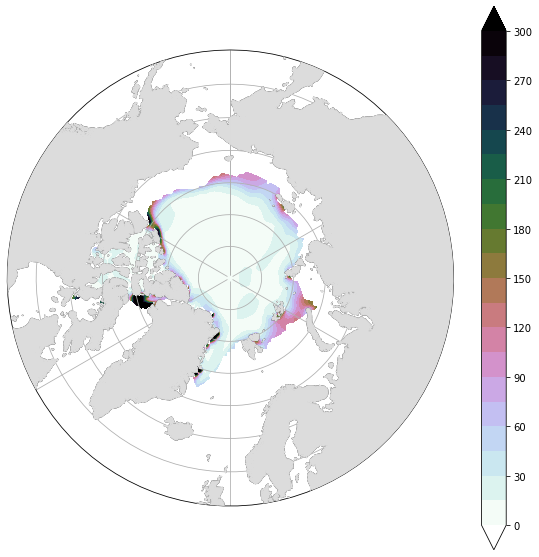

In [559]:
fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection=nps)
fashion_space(ax)
cmap = plt.cm.cubehelix_r
clevs_label = np.linspace(0, 300, 11)
clevs = np.linspace(0, 300, 21)
img = ax.contourf(xs, ys, data,clevs, transform=ccrs.NorthPolarStereo(), cmap=cmap, extend = 'both')
cbar2 = fig.colorbar(img, ax=ax, ticks= clevs_label)
# img = ax.contourf(xs, ys, data, transform=ccrs.NorthPolarStereo(), cmap=cmap, extend = 'both')
# cbar2 = fig.colorbar(img, ax=ax)

In [120]:
f

array([0.00000000e+00, 4.88281250e-04, 9.76562500e-04, ...,
       4.99023438e-01, 4.99511719e-01, 5.00000000e-01])

### Lomb-Scargle Periodogram

In [487]:
y = SIT[:,330,316]
w = np.linspace(0.01, 10, 10000)

In [488]:
pgram = signal.lombscargle(x, y, w, normalize=True)

In [465]:
x = np.arange(0, len(y.time))

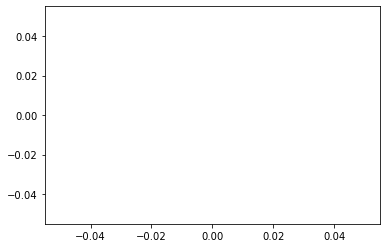

In [490]:
plt.plot(w, pgram)

In [485]:
y = SIT[:,330,316]

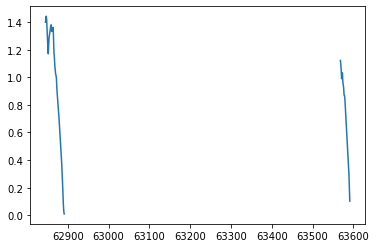

In [486]:
plt.plot(y)

In [483]:
y

<xarray.DataArray 'sithick' (time: 73000)>
array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)
Coordinates:
    lat      float64 9.969e+36
    lon      float64 9.969e+36
    ni       int32 317
    nj       int32 373
  * time     (time) object 1000-01-02 00:00:00 ... 1200-01-01 00:00:00
Attributes: (12/19)
    cell_measures:  area: areacello
    cell_methods:   area: time: mean where sea_ice (comment: mask=siconc)
    comment:        Actual (floe) thickness of sea ice (NOT volume divided by...
    description:    Actual (floe) thickness of sea ice (NOT volume divided by...
    frequency:      day
    id:             sithick
    ...             ...
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Sea Ice Thickness
    type:           real
    units:          m
    variable_id:    sithick

In [489]:
SIT

<xarray.DataArray 'sithick' (time: 73000, nj: 384, ni: 320)>
array([[[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [25.489098, 24.86997 , 26.142994, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [25.491957, 24.872179, 26.142319, ...,       nan,       nan,
               nan],
...
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [28.770388, 26.606035, 27.992212, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
    lat      (nj, ni) float64 -79.22 -79.22 -79.22 ... 9.969e+36 9.969e+36
    lon      (nj, ni) float64 320.6 321.7 322.8 ... 9.969e+36 9.969e+36
  * ni       (ni) int32 1 2 3 4 5 6 7 8 9 ... 313 314 315 316 317 318 319 320
  * nj       (nj) int32 1 2 3 4 5 6 7 8 9 ... 377 378 379 380 381 382 383 384
  * time     (time) object 1000-01-02 00:00:00 ... 1200-01-01 00:00:00
Attributes: (12/19)
    cell_measures:  area: areacello
    cell_methods:   area: time: mean where sea_ice (comment: mask=siconc)
    comment:        Actual (floe) thickness of sea ice (NOT volume divided by...
    description:    Actual (floe) thickness of sea ice (NOT volume divided by...
    frequency:      day
    id:             sithick
    ...             ...
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Sea Ice Thickness
    type:           real
    units:          m
    variable_id:    sithick

### Standard Deviation

In [5]:
SIT = cmip_ds.sithick.fillna(0).compute()
# SIT_blank = SIT.fillna(0)

In [6]:
fs=1 #1 day in Hz (sampling frequency)

nyquist = fs / 2 # 0.5 times the sampling frequency
low_cutoff=0.02 # fraction of nyquist frequency, here  it is 5 days
hi_cutoff = 0.1
print('high cutoff= ',1/hi_cutoff*nyquist,' days') #cutoff=  4.999999999999999  days
print('low cutoff= ',1/low_cutoff*nyquist,' days') #cutoff=  4.999999999999999  days
b, a = signal.butter(5, [low_cutoff, hi_cutoff] , btype='bandpass') #low pass filter

high cutoff=  5.0  days
low cutoff=  25.0  days


In [7]:
SIT_filt = signal.filtfilt(b, a, SIT, axis = 0)

In [8]:
Var = SIT_filt.std(axis = 0)

In [9]:
data = Var

lat = SIT.lat
lon = SIT.lon
nps = ccrs.NorthPolarStereo()

xs,ys,plot_data=convert_coords(lat, lon, data, nps)

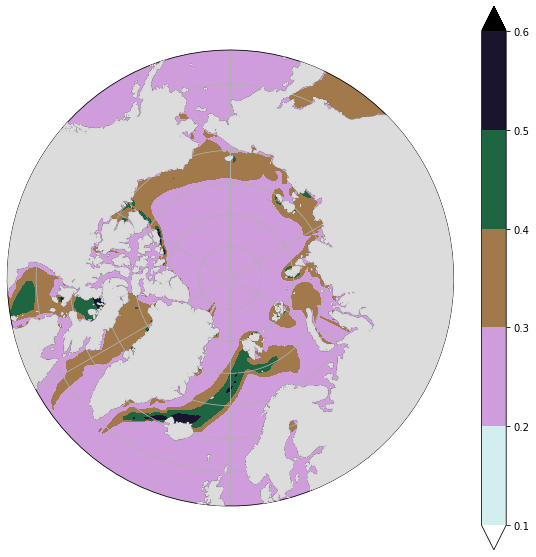

In [10]:
fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection=nps)
fashion_space(ax)
cmap = plt.cm.cubehelix_r
# clevs_label = np.linspace(0, 300, 11)
# clevs = np.linspace(0, 300, 21)
# img = ax.contourf(xs, ys, data,clevs, transform=ccrs.NorthPolarStereo(), cmap=cmap, extend = 'both')
# cbar2 = fig.colorbar(img, ax=ax, ticks= clevs_label)
img = ax.contourf(xs, ys, data, transform=ccrs.NorthPolarStereo(), cmap=cmap, extend = 'both')
cbar2 = fig.colorbar(img, ax=ax)